In [1]:
import sys
import pandas as pd
import numpy as np
import os
os.chdir('/home/labs/barkailab/tamarj/MPBA/')
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
from Bio.Seq import Seq
from matplotlib.patches import Rectangle

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from importlib import reload

# from brokenaxes import brokenaxes
from Bio.Seq import Seq
from functions import params
from functions import parsing
from functions import data_processing as dp
from functions import lib_table_operations as lto
from functions import general_functions as gf

from scipy.stats import zscore
matplotlib.rcParams['pdf.fonttype'] = 42

In [256]:
reload(params)
GP = params.GP.reset_index()
prom_pos_1000 = params.PROM_POS_1000.astype(int)
MNase_seq_wt = params.MNASE_mean
tf_binding_z = zscore(params.TF_SUMPROM,nan_policy='omit')
tf_binding_z = tf_binding_z.iloc[:, ~tf_binding_z.columns.str.contains('DBD')]
context_info = params.CONTEXT_INFO
RES_PATH = params.RES_PATH
libs_info_path = params.libs_info_path

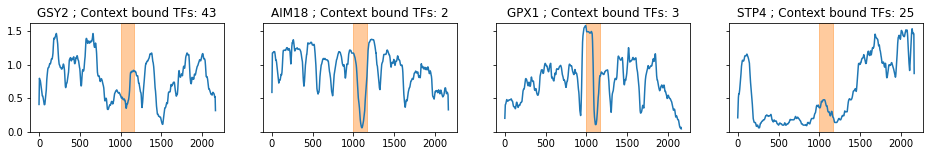

In [257]:
nuc_depleted_context_id = 4
context_info_gene = context_info.drop(nuc_depleted_context_id) # genomic context only
fig,axes = plt.subplots(1,context_info_gene.shape[0],figsize=(16,2),sharey=True)
fig.subplots_adjust(hspace = 0.5)
z_thresh = 3
lib_ind = 1000
lib_len = 164
for row_i, row in context_info_gene.iterrows():
    context_gene = row['Gene'] # main promoter gene
    curr_context_info = context_info_gene.query("Gene == @context_gene")
    chr_num = int(curr_context_info['chr'].values[0])
    context_start_i = int(curr_context_info['start'].values[0])   
    context_end_i = int(curr_context_info['end'].values[0])
    gene_ind = GP.query("Name == @context_gene").index.values[0] # gene id
    prom_locs = prom_pos_1000[gene_ind,:].astype(int) # promoter positions
    signal = np.flip(MNase_seq_wt[chr_num][context_start_i:context_end_i]) # correct orientation   
    prom_ids = [gene_ind]
    bound_tfs_bool = tf_binding_z.iloc[gene_ind,:] > z_thresh # count bount tf according to threshold
    bound_tfs_bool = bound_tfs_bool.to_frame().T
    context_bound_tfs = bound_tfs_bool.columns[bound_tfs_bool.values[0]].values
    
    curr_ax = axes.ravel()[row_i]
    sns.lineplot(x=range(len(signal)),y=gf.smooth(signal,10),ax=curr_ax)
    y_lim = curr_ax.set_ylim(0,1.62)
    curr_ax.add_patch(Rectangle((lib_ind, y_lim[0]), lib_len, abs(y_lim[0])+ abs(y_lim[1]), color='C1', alpha=0.4))    
    curr_ax.set_title(context_gene + ' ; Context bound TFs: ' + str(len(context_bound_tfs)))

## (C) GSY2 library repeat scatter in contexts

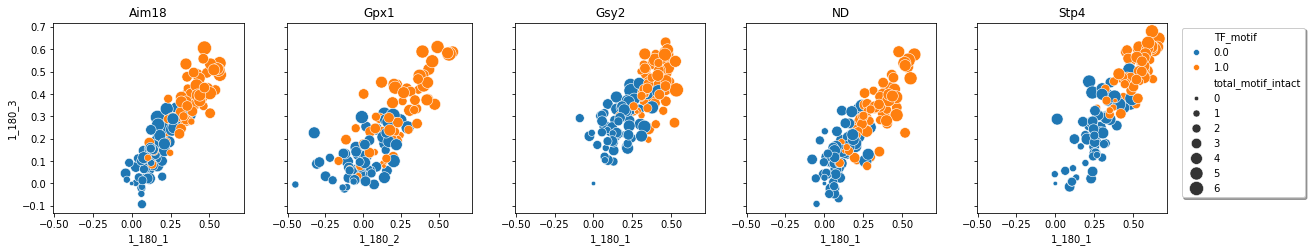

In [260]:
contexts = ['Aim18', 'Gpx1', 'Gsy2', 'ND', 'Stp4']
context_exp = '28'

tf='Msn2'
lib_num='32'
lib_info = dp.get_lib_info(lib_num)
gene = lib_info['gene'].upper()
wt_var_seq = ''.join(lib_info['wt_at_var_loc'])
mut_var_seq = lto.get_mut_var(lib_num)
lib_num_int = int(lib_num)

fig,axes = plt.subplots(1, len(contexts), figsize=(4*len(contexts),3.5),sharey=True,sharex=True)
for context_i, context in enumerate(contexts):
    tf_context = tf+'Context'+context
    
    ##norm data without tp mean
    norm_df_occ = lto.norm_without_biorep_mean(tf+'Context'+context, lib_num, context_exp, None, occ=True) # normlize data
    #remove bad samples
    samples_to_remove = pd.read_csv(os.path.join(libs_info_path, 'samples_to_remove.csv'))
    samples_to_rm = samples_to_remove.query("TF==@tf_context & Lib_number==@lib_num_int ")['Sample_name'].values
    norm_df_occ = norm_df_occ[norm_df_occ.columns.difference(samples_to_rm)]

    #get the two most correlative repeats
    relevant_repeats_inds = norm_df_occ.corr().replace(1,0).max(axis=1).duplicated(keep=False)
    relevant_repeats = relevant_repeats_inds.index[relevant_repeats_inds.values]
    relevant_data = norm_df_occ[relevant_repeats]

    # count TF motifs per sequence
    tf_pos = [annot_i for annot_i, annot in enumerate(lib_info['mut_by_tf']) if tf in annot]
    seqs = norm_df_occ.index # library sequences
    all_seqs_split = np.array([list(seq) for seq in seqs]) # library sequences spli
    tf_intact_motif_seqs = np.zeros((len(seqs),1))
    for pos in tf_pos:
        tf_intact_motif_seqs[all_seqs_split[:,pos]==wt_var_seq[pos]] += 1
    relevant_data['TF_motif'] = tf_intact_motif_seqs
    
    # count other TF motifs per sequence
    intact_pos = np.zeros((len(seqs),len(list(wt_var_seq))))
    for pos_i, pos in enumerate(list(wt_var_seq)):
        intact_pos[:,pos_i] = all_seqs_split[:,pos_i] == pos
    relevant_data['total_motif_intact'] = np.reshape(np.sum(intact_pos, axis=1), (len(seqs),1)) - tf_intact_motif_seqs
    
    curr_ax = axes.ravel()[context_i]
    sns.scatterplot(data=relevant_data, x=relevant_repeats[0], y=relevant_repeats[1], hue='TF_motif',
                    size='total_motif_intact',sizes=(20,200),ax=curr_ax)
    curr_ax.set_title(context)
    curr_ax.set_aspect(1.0/curr_ax.get_data_ratio(), adjustable='box')
    
    curr_ax.get_legend().set_visible(False)
axes.ravel()[0].set_aspect(1.0/axes.ravel()[0].get_data_ratio(), adjustable='box')
    
curr_ax.legend(loc='upper center', bbox_to_anchor=(1.4, 1),fancybox=True, shadow=True, ncol=1)

## (D) Msn2 cooperativity scores in contexts

In [215]:
relevant_files = os.listdir(RES_PATH)
Msn2_context_coop = pd.DataFrame()

genome_exp = '30'
context_exp = '28'
tp='180'
tf= 'Msn2'

# iterate over context files and calculate cooperativity scores
for file in relevant_files:
    if file.split('.')[0].split('_')[-1] != context_exp:
        continue
    strain_context, lib_num, _ = file.split('.')[0].split('_')
    context = strain_context.split('Context')[1]
    norm_df = dp.mean_over_bio_reps(lto.norm_res_data(strain_context, lib_num, context_exp, norm_to=None, occ=None))
    curr_lib_coop = lto.obs_exp_mean_context(tf, lib_num, tp, [tf], norm_df=norm_df)
    curr_lib_coop['Context'] = np.repeat(context,curr_lib_coop.shape[0])
    Msn2_context_coop = pd.concat([Msn2_context_coop, curr_lib_coop])

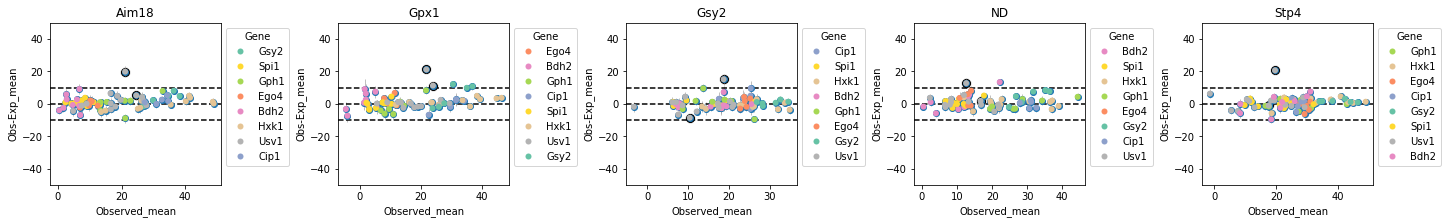

In [221]:
contexts = Msn2_context_coop['Context'].unique()
context_libs = Msn2_context_coop['Gene'].unique()
color_dict = gf.generate_color_dict(sns.color_palette("Set2"), context_libs,1)

observed_mean_df = pd.DataFrame()
delta_mean_df = pd.DataFrame()

fig, axes = plt.subplots(1,5,figsize=(20,3),constrained_layout=True)


for context_i, context in enumerate(contexts):
    curr_ax = axes.ravel()[context_i]
    context_df = Msn2_context_coop.query("Context==@context") 
    
    # find pairs that contains two mutations within same motif (controls)
    self_df = context_df.query("Comb_type == 'Self_comb'")    
    same_mot_df = pd.DataFrame()
    for row_i,row in self_df.iterrows():
        mot_info = dp.get_motif_info_by_pos(row['Lib_num'])   # get motif info 
        tf_mot_info = mot_info.query("TF.str.contains('MSN')").iloc[:,-3:].drop_duplicates()
        comb_pos = np.array(row['Comb'].split('_')).astype(int) # current pair
        mot_info_at_comb = tf_mot_info.query("Pos in @comb_pos") # get motif current pair info
        if mot_info_at_comb.iloc[:,0:-1].drop_duplicates().shape[0] == 1: # keep same motif controls
            same_mot_df = pd.concat([same_mot_df,row.to_frame().T])
    
    ## plot pairs cooperativity scores for each context
    sns.scatterplot(data=same_mot_df, x='Observed_mean', y='Obs-Exp_mean',color='k', s=100, ax=curr_ax)
    
    sns.scatterplot(data=context_df, x='Observed_mean', y='Obs-Exp_mean',
                    hue='Gene', linewidth=0,palette=color_dict,zorder=20, ax=curr_ax)
    
    curr_ax.errorbar(context_df['Observed_mean'], context_df['Obs-Exp_mean'], yerr=context_df['Obs-Exp_sem'],ecolor='grey',elinewidth=0.5, fmt='o')

    curr_ax.set_title(context)
    sns.move_legend(curr_ax, "upper left", bbox_to_anchor=(1, 1), ncol=1)
    curr_ax.axline((0,0), slope=0, color='k', linestyle='--')
    curr_ax.axline((0,10), slope=0, color='k', linestyle='--')
    curr_ax.axline((0,-10), slope=0, color='k', linestyle='--')
    curr_ax.set_ylim([-50, 50])

## (F) GSY2 repeat sactter in genome

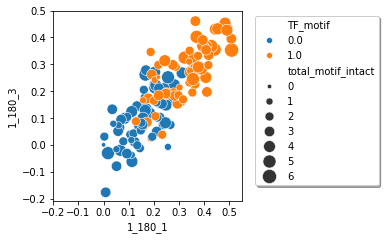

In [261]:
tf='Msn2'
lib_num='32'
genome_exp_num = '30'
lib_info = dp.get_lib_info(lib_num)
gene = lib_info['gene'].upper()
wt_var_seq = ''.join(lib_info['wt_at_var_loc'])
mut_var_seq = lto.get_mut_var(lib_num)
file_name = '_'.join([tf, lib_num, genome_exp_num + '.csv'])  # find results file ('tf_libnum_exp.csv')

fig,curr_ax = plt.subplots(1, 1, figsize=(4,3.5),sharey=True,sharex=True)

##norm data without tp mean
norm_df_occ = lto.norm_without_biorep_mean(tf, lib_num, genome_exp_num, None, occ=True) # normlize data
#remove bad samples
samples_to_remove = pd.read_csv(os.path.join(libs_info_path, 'samples_to_remove.csv'))
samples_to_rm = samples_to_remove.query("TF==@tf_context & Lib_number==@lib_num_int ")['Sample_name'].values
norm_df_occ = norm_df_occ[norm_df_occ.columns.difference(samples_to_rm)]

#get the two most correlative repeats
relevant_repeats_inds = norm_df_occ.corr().replace(1,0).max(axis=1).duplicated(keep=False)
relevant_repeats = relevant_repeats_inds.index[relevant_repeats_inds.values]
relevant_data = norm_df_occ[relevant_repeats]

# count TF motifs per sequence
tf_pos = [annot_i for annot_i, annot in enumerate(lib_info['mut_by_tf']) if tf in annot]
seqs = norm_df_occ.index # library sequences
all_seqs_split = np.array([list(seq) for seq in seqs]) # library sequences spli
tf_intact_motif_seqs = np.zeros((len(seqs),1))
for pos in tf_pos:
    tf_intact_motif_seqs[all_seqs_split[:,pos]==wt_var_seq[pos]] += 1
relevant_data['TF_motif'] = tf_intact_motif_seqs

# count other TF motifs per sequence
intact_pos = np.zeros((len(seqs),len(list(wt_var_seq))))
for pos_i, pos in enumerate(list(wt_var_seq)):
    intact_pos[:,pos_i] = all_seqs_split[:,pos_i] == pos
relevant_data['total_motif_intact'] = np.reshape(np.sum(intact_pos, axis=1), (len(seqs),1)) - tf_intact_motif_seqs
sns.scatterplot(data=relevant_data, x=relevant_repeats[0], y=relevant_repeats[1], hue='TF_motif',
                size='total_motif_intact',sizes=(20,200),ax=curr_ax)

curr_ax.get_legend().set_visible(False)

curr_ax.legend(loc='upper center', bbox_to_anchor=(1.4, 1),fancybox=True, shadow=True, ncol=1)
curr_ax.set_xlim(-0.05, 0.55)
curr_ax.set_xlim(-0.2, 0.55)
curr_ax.set_aspect(1.0/curr_ax.get_data_ratio(), adjustable='box')
curr_ax.set_xticks(np.arange(-0.2,0.6,0.1))
curr_ax.set_yticks(np.arange(-0.2,0.6,0.1))

## (G) - Occupancy a wild type variant - genome libraries

<ErrorbarContainer object of 3 artists>

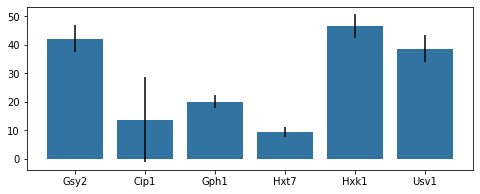

In [242]:
genome_exp = '30'
tp='180'
tf= 'Msn2'
genome_libs = ['32', '66', '72', '86', '87', '88']
norm_seqs_by_lib = {}
wt_dict = {}
tf_on_dict = {}
for lib_num in genome_libs:
    lib_info = dp.get_lib_info(lib_num)    
    wt_var_seq = ''.join(lib_info['wt_at_var_loc'])
    tf_pos = [annot_i for annot_i, annot in enumerate(lib_info['mut_by_tf']) if tf[0:3] in annot]
        
    lib_data = lto.norm_without_biorep_mean(tf, lib_num, genome_exp_num, None, occ=True)*100 # normlize data
    wt_dict[lib_info['gene']] = lib_data.loc[wt_var_seq].mean() # get wild type variant mean value
    wt_sem_dict[lib_info['gene']] = lib_data.loc[wt_var_seq].sem() # get wild type variant sem value
    
f,ax = plt.subplots(1,1,figsize=(8,3))
sns.barplot(data=wt_dict, ax=ax)
ax.errorbar(x=list(wt_dict.keys()), y=list(wt_dict.values()), yerr=list(wt_sem_dict.values()),fmt="none", c= "k")

## (H) Msn2 occupancy in genome libraries

(-50.0, 50.0)

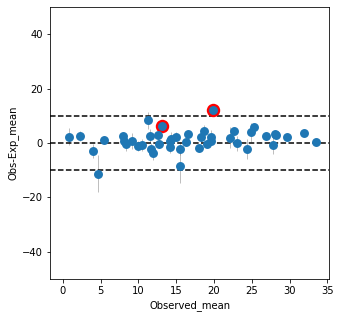

In [245]:
genome_libs_coop = pd.DataFrame()
genome_exp = '30'
tp='180'
tf= 'Msn2'
genome_libs = ['32', '66', '72', '86', '87', '88']

# calculate cooperativity scores for genome libs
for lib_num in genome_libs:
    norm_df_genome = dp.mean_over_bio_reps(lto.norm_res_data(tf, lib_num, genome_exp, norm_to=None, occ=None))
    curr_lib_coop = lto.obs_exp_mean_context(tf, lib_num, tp, [tf], norm_df=norm_df_genome)
    genome_libs_coop = pd.concat([genome_libs_coop, curr_lib_coop])   

# subset cooperativity score df by same motif control pairs
self_df = genome_libs_coop.query("Comb_type == 'Self_comb'")
same_mot_df = pd.DataFrame()
for row_i,row in self_df.iterrows():
    mot_info = dp.get_motif_info_by_pos(row['Lib_num'])    
    tf_mot_info = mot_info.query("TF.str.contains('MSN')").iloc[:,-3:].drop_duplicates()
    comb_pos = np.array(row['Comb'].split('_')).astype(int)
    mot_info_at_comb = tf_mot_info.query("Pos in @comb_pos")
    if mot_info_at_comb.iloc[:,0:-1].drop_duplicates().shape[0] == 1:
        same_mot_df = pd.concat([same_mot_df,row.to_frame().T])


fig, ax = plt.subplots(1,1,figsize=(5,5))
sns.scatterplot(data=same_mot_df, x='Observed_mean', y='Obs-Exp_mean', color='red',
            s=180, zorder=20, linewidth=0, ax=ax)
sns.scatterplot(data=genome_libs_coop, x='Observed_mean', y='Obs-Exp_mean', s=80, zorder=20, linewidth=0, ax=ax)
ax.errorbar(genome_libs_coop['Observed_mean'], genome_libs_coop['Obs-Exp_mean'], yerr=genome_libs_coop['Obs-Exp_sem'],ecolor='grey',elinewidth=0.5, fmt='o')
ax.axline((0,0), slope=0, color='k', linestyle='--')
ax.axline((0,10), slope=0, color='k', linestyle='--')
ax.axline((0,-10), slope=0, color='k', linestyle='--')
ax.set_ylim([-50, 50])